# Experiment description
## Hypothesis: 
Predictability localidad values are similar (presents low variance) among intervals on full dataset

## Method: 
- Remove outliers
- Measure predictability for 7 days timewindows and levelCrime=3 on intervals for full dataset (months, bimesters, semesters)
- Implement a metric to compare the difference among predictability values

## Parameters: 
- Time windows: 7
- Crime levels: 3
- Aggregation: localidades

## Built-in methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import scipy
import math
from math import pi
import geopandas as gpd
import plotly.express as px
%matplotlib inline

In [2]:
workingPath= '/Users/anamaria/Desktop/dev/security_project/'

In [3]:
def set_initial_dataset_day(df_by_date,name_day):
    df_by_date = df_by_date.reset_index()
    df_by_date['day_of_week'] = df_by_date['date'].dt.day_name()
    monday_idx = df_by_date.index[df_by_date['day_of_week'] == name_day].tolist()[0]
    df_by_date = df_by_date[monday_idx:].set_index('date').drop(['day_of_week'],axis=1)
    return df_by_date

In [4]:
# Methods for time windows
def im2patches(im,n):
    patches = [];
    for i in range(len(im)-n):
        patch = im[i:(i+n-1)]        
        patch = patch - np.nanmean(patch);
        if(np.linalg.norm(patch)>0):
            patch = patch/np.linalg.norm(patch);
        if i==0:
            patches = patch;
        else:
            patches = np.vstack((patches,patch))
    return patches;

def writeEmbeding(timeSeries,lenWindow,samplePath, scenarioName):
    slicingWindows = im2patches(timeSeries,lenWindow);
    experimentPath = 'periodicity_experiments/predictability/slicing/'
    prevStation = str(samplePath);
    with open(workingPath+experimentPath+'slicingWindows'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = slicingWindows.tolist();                        
        pickle.dump(lv, f, protocol=2)

    experimentPath = 'periodicity_experiments/predictability/timeSeries/'    
    with open(workingPath+experimentPath+'timeSeries'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = timeSeries.tolist();                        
        pickle.dump(lv, f, protocol=2)



In [5]:
#Methods for predictability
def getBarcode(samplePath,lenWindow,scenarioName):
    experimentPath = 'periodicity_experiments/predictability/'
    barcode = [];

    with open(workingPath+experimentPath+'timeSeries/'+'timeSeries_'+samplePath+"_"+str(scenarioName)+'_'+str(lenWindow)+'_'+'.pickle', 'rb') as f:
            timeSeries = pickle.load(f);            
    return (barcode,timeSeries);

def computeBarcodeEntropy(barsLenB0):
    barlen = np.array(barsLenB0);
    barlen = barlen/barlen.sum();
    hbc = 0;
    for i in range(barlen.shape[0]):
        if barlen[i]!=0:
            hbc = hbc-(barlen[i])*np.log(barlen[i]);
    return hbc;


def computeGeneralPredictability(timeSeries,binsData,lenWindow):
    # Colwell, R. K. (1974). Predictability, constancy, and contingency of periodic phenomena. Ecology, 55(5), 1148-1153.
    # Normalize the caudal values
    nLevels = binsData.shape[0]-1;
    matStations = np.array(timeSeries).reshape((np.array(timeSeries).shape[0]//lenWindow,lenWindow))    

    grandMean = np.mean(np.mean(matStations));
    #matStations = matStations / grandMean;
    N = np.zeros((nLevels,lenWindow));
    for i in range(1,matStations.shape[1]): 
        # Computes histograms per columns
        hist, bin_edges = np.histogram(matStations[:,i],bins = binsData);
        N[:,i] = hist;
    X = np.sum(N, axis=0);
    Y = np.sum(N, axis=1);
    Z = np.sum(Y);
    hx = 0;
    hy = 0;
    hxy = 0;
    for j in range(X.shape[0]):
        if X[j]!=0:
            hx = hx-(X[j]/Z)*np.log(X[j]/Z);
            
    for i in range(Y.shape[0]):
        if Y[i]!=0:
            hy = hy-(Y[i]/Z)*np.log(Y[i]/Z);
            
    for i in range(Y.shape[0]):
        for j in range(X.shape[0]):
            if N[i,j]!=0:
                hxy = hxy-((N[i,j]/Z)*np.log(N[i,j]/Z));    
    
    # predictability
    p = 1 - (hxy - hx)/np.log(N.shape[0]);
    # constancy
    c = 1 - hy/np.log(N.shape[0]);
    # Returns constancy and contingency
    return (c,p-c,p);



In [6]:
def preprocess_df(df,min_date_period,max_date_period):
    df=df.drop(columns=['PERIODO_TS','LOCALIDAD'])
    #Remove outliers
    q_hi = df["total_eventos"].quantile(0.99)
    df = df[(df["total_eventos"] < q_hi)]

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min_date_period, max_date_period)
    df = df.reindex(idx, fill_value=int(df["total_eventos"].mean()))
    df = df.reset_index().rename(columns={'index': 'date'}).set_index('date')
    
    #Make sure dataset starts on Monday for the experiment
    df = set_initial_dataset_day(df,'Monday')
    
    return df

In [7]:
def saveTimeSeries(df,min_date_period,max_date_period,localidad, lenWindow, expName):       
    df_values = pd.Series(df['total_eventos']).values
    lT=get_LT(df, lenWindow)
    df_values = df_values[0:lT]
    writeEmbeding(df_values,lenWindow,expName,localidad)

In [8]:
def get_LT(df_by_period,lenWindow):
    min_date = df_by_period.reset_index().date.min()
    max_date = df_by_period.reset_index().date.max()
    samples_num = (max_date.date()-min_date.date()).days
    lT = samples_num//lenWindow * lenWindow
    return lT

In [9]:
def predictability_experiment_localidades(df_by_date,min_date_period,max_date_period,lenWindow,localidadesList,Levels,expName,periodName):
    #workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/';

    flagF = True;
    for localidad in localidadesList:
        #write embeding
        df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]        
        df_by_localidad = preprocess_df(df_by_localidad,min_date_period,max_date_period)
        #print(df_by_localidad["total_eventos"])
        saveTimeSeries(df_by_localidad,min_date_period,max_date_period,localidad, lenWindow, expName)
        
        for nLevels in Levels:
            (barcode,timeSeries) = getBarcode(expName,lenWindow,localidad);
            binsLevels = np.linspace(np.min(timeSeries),np.max(timeSeries),nLevels);
            c,m,p = computeGeneralPredictability(timeSeries,binsLevels,lenWindow)

            if flagF==True:
                flagF = False
                predValues = np.array([expName,periodName,localidad,lenWindow,nLevels,p,m,c]);
            else:
                predValues = np.vstack((predValues, [expName,periodName,localidad,lenWindow,nLevels,p,m,c]))

    return predValues
        
    

In [10]:
def table_predictability_variance(df_agressiveBehavior,lenWindow,localidadesList,yAxisCategories,name_experiment,nLevel):
    join=df_agressiveBehavior.pivot('localidad','period','p_variance')
    var1_order = []
    var2_order = yAxisCategories
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)
    
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    fig.set_size_inches(6, 6)
    g=sns.heatmap(join.astype('float'),annot=True,fmt=".2",linewidths=0,cmap="Blues",cbar=False)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_ylabel("Locality")
    ax.set_xlabel("Period")
    file_path = 'periodicity_experiments/predictability/figures/'
    plt.savefig(workingPath+file_path+'table_'+str(name_experiment)+'_p_variance_time_'+str(lenWindow)+'_levels_'+str(nLevel),dpi=300,bbox_inches = "tight")
    plt.show()

In [11]:
def map_localidad(ax,df,col_localidad,col_vals,vmin=None,vmax=None):
  loc_geo=workingPath+"assets/localidades_polygon.json"
  loc_=gpd.read_file(loc_geo)
  loc_=loc_.merge(df,left_on='LocNombre',right_on=col_localidad)
  loc_.plot(cmap='viridis',column=col_vals,legend=True,ax=ax,vmin=vmin,vmax=vmax)  

In [12]:
def map_predictability(df_crime, crime_level, lenWindow,name_experiment):
    subdata = df_crime[df_crime['crime_level']==crime_level]
    subdata = subdata[subdata['lenWindow']==str(lenWindow)]
    subdata["predictability"] = pd.to_numeric(subdata["predictability"])
    
    fig, ax = plt.subplots(figsize=(12,12))
    map_localidad(ax,subdata,'localidad','predictability')
    ax.axis('off')
    file_path = 'periodicity_experiments/predictability/figures/'
    plt.savefig(workingPath+file_path+'map_aggressiveBehavior_localidades'+str(name_experiment)+'_predictability_time_'+str(lenWindow)+'_levels_'+str(crime_level),dpi=300,bbox_inches = "tight")
    plt.show()

In [13]:
def build_semester_list(year,semester=1):
    if semester == 1:
        month_list = ['01','02','03','04','05','06']
    if semester == 2:
        month_list = ['07','08','09','10','11','12']
    semester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(semester_list))

def build_trimester_list(year,trimester=1):
    if trimester == 1:
        month_list = ['01','02','03']
    if trimester == 2:
        month_list = ['04','05','06']
    if trimester == 3:
        month_list = ['07','08','09']
    if trimester == 4:
        month_list = ['10','11','12']
    trimester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(trimester_list))

def build_bimester_list(year,bimester=1):
    if bimester == 1:
        month_list = ['01','02']
    if bimester == 2:
        month_list = ['03','04']
    if bimester == 3:
        month_list = ['05','06']
    if bimester == 4:
        month_list = ['07','08']
    if bimester == 5:
        month_list = ['09','10']
    if bimester == 6:
        month_list = ['11','12']
    bimester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(bimester_list))

## Load data

In [14]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_nuse_11022020.csv'
df_input = pd.read_csv(data_location,delimiter=",")

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [15]:
df_input['date']=pd.to_datetime(df_input['FECHA']).dt.strftime('%Y-%m-%d')
df_input['date']=pd.to_datetime(df_input['date'],format='%Y-%m-%d')
df_by_date = pd.DataFrame(df_input.groupby(['date','PERIODO_TS','LOCALIDAD']).size(),columns=["total_eventos"])

In [16]:
df_by_date = df_by_date.reset_index().set_index('date')

## Localidades, semester

In [ ]:
Levels=[3]
lenWindow = 7
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')
localidadesList.remove('SUMAPAZ')

In [ ]:
years = list(df_input['ANIO'].unique())
years.remove(2019)
semesters = [1, 2]

In [ ]:
predValues_array = []
for year in years:
    for semester in semesters:
        period_list = build_semester_list(str(year),semester)
        print(period_list)
        df_by_period=df_by_date[df_by_date.PERIODO_TS.isin(period_list)]

        min_date_on_period = df_by_period.reset_index().date.min()
        max_date_on_period = df_by_period.reset_index().date.max()

        expName = 'aggressiveBehavior_localidad_by_semester_full_dataset'
        periodName = str(year)+'-'+str(semester)
        predValues = predictability_experiment_localidades(df_by_period,min_date_on_period,max_date_on_period,lenWindow,localidadesList,Levels,expName,periodName)
        predValues_array = predValues_array + list(predValues)
    
df_prediction = pd.DataFrame(predValues_array, columns=['experiment_name','period','localidad','lenWindow','crime_level','predictability','contingency','constancy'])


In [ ]:
df_prediction.loc[df_prediction.period.str.contains("-1"), 'semester'] = 'I'
df_prediction.loc[df_prediction.period.str.contains("-2"), 'semester'] = 'II'
df_prediction["year"] = df_prediction.period.str.extract(r'(\d{4})')
df_prediction['predictability']=pd.to_numeric(df_prediction['predictability'])

In [ ]:
semesterList = df_prediction.semester.unique()
flagF = True
for localidad in localidadesList:
    df_by_localidad = df_prediction.loc[df_prediction['localidad'] == localidad]
    for semester in semesterList:
        df_by_period = df_by_localidad.loc[df_by_localidad['semester'] == semester]
        meanPredictability = df_by_period.loc[:,"predictability"].mean()
        currentVariance = df_by_period.loc[:,"predictability"].var()
        if flagF==True:
            flagF = False
            varValues = np.array([localidad,semester,meanPredictability,currentVariance]);
        else:
            varValues = np.vstack((varValues, [localidad,semester,meanPredictability,currentVariance]))

In [ ]:
df_variance_prediction = pd.DataFrame(varValues, columns=['localidad','period','p','p_variance'])
periodCategories = list(df_variance_prediction['period'].unique())
table_predictability_variance(df_variance_prediction,lenWindow,localidadesList,periodCategories,expName,Levels[0])

## Localidades, trimester

In [ ]:
Levels=[3]
lenWindow = 7
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')
localidadesList.remove('SUMAPAZ')

In [ ]:
years = list(df_input['ANIO'].unique())
years.remove(2019)
trimesters = [1, 2, 3, 4]

In [ ]:
predValues_array = []
for year in years:
    for trimester in trimesters:
        period_list = build_trimester_list(str(year),trimester)
        print(period_list)
        df_by_period=df_by_date[df_by_date.PERIODO_TS.isin(period_list)]

        min_date_on_period = df_by_period.reset_index().date.min()
        max_date_on_period = df_by_period.reset_index().date.max()

        expName = 'aggressiveBehavior_localidad_by_trimester_full_dataset'
        periodName = str(year)+'-'+str(trimester)
        predValues = predictability_experiment_localidades(df_by_period,min_date_on_period,max_date_on_period,lenWindow,localidadesList,Levels,expName,periodName)
        predValues_array = predValues_array + list(predValues)
    
df_prediction = pd.DataFrame(predValues_array, columns=['experiment_name','period','localidad','lenWindow','crime_level','predictability','contingency','constancy'])



In [ ]:
df_prediction.loc[df_prediction.period.str.contains("-1"), 'trimester'] = 'I'
df_prediction.loc[df_prediction.period.str.contains("-2"), 'trimester'] = 'II'
df_prediction.loc[df_prediction.period.str.contains("-3"), 'trimester'] = 'III'
df_prediction.loc[df_prediction.period.str.contains("-4"), 'trimester'] = 'IV'
df_prediction["year"] = df_prediction.period.str.extract(r'(\d{4})')
df_prediction['predictability']=pd.to_numeric(df_prediction['predictability'])

In [ ]:
trimesterList = df_prediction.trimester.unique()
flagF = True
for localidad in localidadesList:
    df_by_localidad = df_prediction.loc[df_prediction['localidad'] == localidad]
    for trimester in trimesterList:
        df_by_period = df_by_localidad.loc[df_by_localidad['trimester'] == trimester]
        meanPredictability = df_by_period.loc[:,"predictability"].mean()
        currentVariance = df_by_period.loc[:,"predictability"].var()
        if flagF==True:
            flagF = False
            varValues = np.array([localidad,trimester,meanPredictability,currentVariance]);
        else:
            varValues = np.vstack((varValues, [localidad,trimester,meanPredictability,currentVariance]))

In [ ]:
df_variance_prediction = pd.DataFrame(varValues, columns=['localidad','period','p','p_variance'])
periodCategories = list(df_variance_prediction['period'].unique())
table_predictability_variance(df_variance_prediction,lenWindow,localidadesList,periodCategories,expName,Levels[0])

## Localidades, bimester

In [17]:
Levels=[3]
lenWindow = 7
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')
localidadesList.remove('SUMAPAZ')

In [18]:
years = list(df_input['ANIO'].unique())
years.remove(2019)
bimesters = [1, 2, 3, 4, 5, 6]

In [19]:
predValues_array = []
for year in years:
    for bimester in bimesters:
        period_list = build_bimester_list(str(year),bimester)
        print(period_list)
        df_by_period=df_by_date[df_by_date.PERIODO_TS.isin(period_list)]

        min_date_on_period = df_by_period.reset_index().date.min()
        max_date_on_period = df_by_period.reset_index().date.max()

        expName = 'aggressiveBehavior_localidad_by_bimester_full_dataset'
        periodName = str(year)+'-'+str(bimester)
        predValues = predictability_experiment_localidades(df_by_period,min_date_on_period,max_date_on_period,lenWindow,localidadesList,Levels,expName,periodName)
        predValues_array = predValues_array + list(predValues)
    
df_prediction = pd.DataFrame(predValues_array, columns=['experiment_name','period','localidad','lenWindow','crime_level','predictability','contingency','constancy'])


['2014/01', '2014/02']
['2014/03', '2014/04']
['2014/05', '2014/06']
['2014/07', '2014/08']
['2014/09', '2014/10']
['2014/11', '2014/12']
['2015/01', '2015/02']
['2015/03', '2015/04']
['2015/05', '2015/06']
['2015/07', '2015/08']
['2015/09', '2015/10']
['2015/11', '2015/12']
['2016/01', '2016/02']
['2016/03', '2016/04']
['2016/05', '2016/06']
['2016/07', '2016/08']
['2016/09', '2016/10']
['2016/11', '2016/12']
['2017/01', '2017/02']
['2017/03', '2017/04']
['2017/05', '2017/06']
['2017/07', '2017/08']
['2017/09', '2017/10']
['2017/11', '2017/12']
['2018/01', '2018/02']
['2018/03', '2018/04']
['2018/05', '2018/06']
['2018/07', '2018/08']
['2018/09', '2018/10']
['2018/11', '2018/12']


In [20]:
df_prediction.loc[df_prediction.period.str.contains("-1"), 'bimester'] = 'JAN-FEB'
df_prediction.loc[df_prediction.period.str.contains("-2"), 'bimester'] = 'MAR-APR'
df_prediction.loc[df_prediction.period.str.contains("-3"), 'bimester'] = 'MAY-JUN'
df_prediction.loc[df_prediction.period.str.contains("-4"), 'bimester'] = 'JUL-AUG'
df_prediction.loc[df_prediction.period.str.contains("-5"), 'bimester'] = 'SEP-OCT'
df_prediction.loc[df_prediction.period.str.contains("-6"), 'bimester'] = 'NOV-DEC'
df_prediction["year"] = df_prediction.period.str.extract(r'(\d{4})')
df_prediction['predictability']=pd.to_numeric(df_prediction['predictability'])

In [21]:
bimesterList = df_prediction.bimester.unique()
flagF = True
for localidad in localidadesList:
    df_by_localidad = df_prediction.loc[df_prediction['localidad'] == localidad]
    for bimester in bimesterList:
        df_by_period = df_by_localidad.loc[df_by_localidad['bimester'] == bimester]
        meanPredictability = df_by_period.loc[:,"predictability"].mean()
        currentVariance = df_by_period.loc[:,"predictability"].var().round(3)
        if flagF==True:
            flagF = False
            varValues = np.array([localidad,bimester,meanPredictability,currentVariance]);
        else:
            varValues = np.vstack((varValues, [localidad,bimester,meanPredictability,currentVariance]))

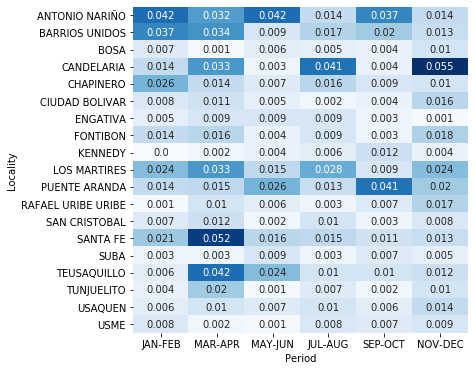

In [22]:
df_variance_prediction = pd.DataFrame(varValues, columns=['localidad','period','p','p_variance'])
periodCategories = list(df_variance_prediction['period'].unique())
table_predictability_variance(df_variance_prediction,lenWindow,localidadesList,periodCategories,expName,Levels[0])

## Localidades, months

In [ ]:
Levels=[3]
lenWindow = 7
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')
localidadesList.remove('SUMAPAZ')

In [ ]:
years = list(df_input['ANIO'].unique())
years.remove(2019)
all_months = df_by_date.PERIODO_TS.unique()
all_months

In [ ]:
import re
regex = re.compile(r'(2019)')
months = [m for m in all_months if not regex.match(m)]
print(months)

In [ ]:
# NOTE: change size table
#fig.set_size_inches(14, 6)

In [ ]:
predValues_array = []
for month in months:
    period_list = []
    period_list.append(month)
    print(period_list)
    df_by_period=df_by_date[df_by_date.PERIODO_TS.isin(period_list)]

    min_date_on_period = df_by_period.reset_index().date.min()
    max_date_on_period = df_by_period.reset_index().date.max()

    expName = 'aggressiveBehavior_localidad_by_month_full_dataset'
    periodName = str(month)
    predValues = predictability_experiment_localidades(df_by_period,min_date_on_period,max_date_on_period,lenWindow,localidadesList,Levels,expName,periodName)
    predValues_array = predValues_array + list(predValues)
    
df_prediction = pd.DataFrame(predValues_array, columns=['experiment_name','period','localidad','lenWindow','crime_level','predictability','contingency','constancy'])


In [ ]:
df_prediction["month"] = df_prediction.period.str.extract(r'(\d{2}$)')
df_prediction["year"] = df_prediction.period.str.extract(r'(\d{4})')
df_prediction['predictability']=pd.to_numeric(df_prediction['predictability'])

In [ ]:
df_prediction

In [ ]:
monthList = df_prediction.month.unique()
flagF = True
for localidad in localidadesList:
    df_by_localidad = df_prediction.loc[df_prediction['localidad'] == localidad]
    for month in monthList:
        df_by_period = df_by_localidad.loc[df_by_localidad['month'] == month]
        meanPredictability = df_by_period.loc[:,"predictability"].mean()
        currentVariance = df_by_period.loc[:,"predictability"].var()
        if flagF==True:
            flagF = False
            varValues = np.array([localidad,month,meanPredictability,currentVariance]);
        else:
            varValues = np.vstack((varValues, [localidad,month,meanPredictability,currentVariance]))

In [ ]:
df_variance_prediction = pd.DataFrame(varValues, columns=['localidad','period','p','p_variance'])
df_variance_prediction['p']=pd.to_numeric(df_variance_prediction['p'])
df_variance_prediction['p_variance']=pd.to_numeric(df_variance_prediction['p_variance'])
periodCategories = list(df_variance_prediction['period'].unique())
table_predictability_variance(df_variance_prediction,lenWindow,localidadesList,periodCategories,expName,Levels[0])

In [ ]:
df_variance_prediction.dtypes

In [ ]:
flagF = True
for localidad in localidadesList:
    df_by_localidad = df_variance_prediction.loc[df_variance_prediction['localidad'] == localidad]
    totalVariance = df_by_localidad.loc[:,"p_variance"].sum()
    if flagF==True:
        flagF = False
        varianceArray = np.array([localidad,totalVariance]);
    else:
        varianceArray = np.vstack((varianceArray, [localidad,totalVariance]))

In [ ]:
varianceArray

### Localidades with higher predictability values

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "CIUDAD BOLIVAR"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "BOSA"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

### Localidades with low predictability values

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "TEUSAQUILLO"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "LOS MARTIRES"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

### Localidades with the lowest variance index

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "KENNEDY"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "SAN CRISTOBAL"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

### Localidades with the highest variance index

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "SANTA FE"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "PUENTE ARANDA"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()